In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torchvision import transforms
from torch.utils.data import Dataset

#plot
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np 
import torchmetrics as tm


In [2]:
import sys
sys.path.append('/cephyr/users/olebal/Alvis/lora_ensembles/equivariant-posteriors')

In [3]:
import numpy as np
import dill as pickle

import torch

def read_res_from_dill(path):  
    with open(path, 'rb') as fp:
        res = pickle.load(fp)   
    return res

IGNORE_INDEX = -100
def calculate_mean_softmax_probs (softmax_probs_ensemble: torch.Tensor) -> torch.Tensor:

    mean_softmax_probs = torch.mean(softmax_probs_ensemble, dim=0)
    return mean_softmax_probs


def calculate_accuracy_over_ens(
    softmax_probs_ensemble: torch.Tensor, 
    final_targets: torch.Tensor
) -> float:
    """
    Calculate overall accuracy of the ensemble.

    Args:
        softmax_probs_ensemble (torch.Tensor): Mean softmax probabilities across the ensemble.
        final_targets (torch.Tensor): Target labels.

    Returns:
        float: Accuracy of the ensemble.
    """
    mean_softmax_probs = calculate_mean_softmax_probs(softmax_probs_ensemble)
    predicted_labels = torch.argmax(mean_softmax_probs, dim=-1)
    correct_predictions = torch.sum(predicted_labels == final_targets)
    accuracy = correct_predictions.item() / len(final_targets)

    return accuracy

def calculate_generative_loss_ens(
    ens_softmax_probs: torch.Tensor, 
    ens_targets: torch.Tensor, 
    epsilon: float = 1e-9
) -> torch.Tensor:
    """
    Calculate generative loss for the ensemble, focusing on specific classes.

    Args:
        ens_softmax_probs (torch.Tensor): Ensemble softmax probabilities.
        ens_targets (torch.Tensor): Ensemble targets.
        epsilon (float): Small value to prevent log(0). Default is 1e-6.

    Returns:
        torch.Tensor: Calculated loss.
    """

    # Calculate the mean softmax probabilities for the relevant classes
    mean_softmax_probs = calculate_mean_softmax_probs(ens_softmax_probs)

    # Log probabilities
    log_probs = torch.log(mean_softmax_probs + epsilon)

    # Calculate loss
    loss = F.nll_loss(log_probs, ens_targets, reduction='mean', ignore_index=IGNORE_INDEX)
    return loss.item()

def calculate_ce_over_ens(
    ens_softmax_probs: torch.Tensor, 
    ens_targets: torch.Tensor
) -> torch.Tensor:
    """
    Calculate calibration error over ensemble softmax probabilities.

    Args:
        ens_softmax_probs (torch.Tensor): Ensemble softmax probabilities.
        ens_targets (torch.Tensor): Targets for the ensemble.

    Returns:
        torch.Tensor: Calibration error.
    """
    mean_softmax_probs = calculate_mean_softmax_probs(ens_softmax_probs)
    num_classes = mean_softmax_probs.shape[-1]

    return tm.functional.classification.calibration_error(
        mean_softmax_probs,
        ens_targets,
        n_bins=10,
        num_classes=num_classes,
        task="multiclass",
    ).item()


In [4]:
def calculate_roc_auc_score(
    y_true: torch.Tensor, 
    y_scores: torch.Tensor
) -> float:
    """
    Calculate the ROC AUC score.

    Args:
        y_true (torch.Tensor): Ground truth binary labels.
        y_scores (torch.Tensor): Predicted scores.

    Returns:
        float: ROC AUC score.
    """
    y_true = torch.tensor(y_true, dtype=torch.bool)
    y_scores = torch.tensor(y_scores, dtype=torch.float32)

    desc_score_indices = torch.argsort(y_scores, descending=True)
    y_true = y_true[desc_score_indices]
    y_scores = y_scores[desc_score_indices]

    n_positives = torch.sum(y_true)
    n_negatives = y_true.size(0) - n_positives

    tpr = torch.cumsum(y_true, dim=0) / n_positives
    fpr = torch.cumsum(~y_true, dim=0) / n_negatives

    tpr = torch.cat([torch.zeros(1), tpr])
    fpr = torch.cat([torch.zeros(1), fpr])

    auroc = torch.trapz(tpr, fpr)

    return auroc.item()

def calculate_ood_performance_auroc(
    in_domain_scores: torch.Tensor, 
    out_domain_scores: torch.Tensor
) -> float:
    """
    Calculate OOD performance using AUROC score.

    Args:
        in_domain_scores (torch.Tensor): Scores for in-domain samples.
        out_domain_scores (torch.Tensor): Scores for out-of-domain samples.

    Returns:
        float: AUROC score representing OOD performance.
    """
    labels_in_domain = torch.zeros_like(in_domain_scores)
    labels_out_domain = torch.ones_like(out_domain_scores)

    all_scores = torch.cat([in_domain_scores, out_domain_scores])
    all_labels = torch.cat([labels_in_domain, labels_out_domain])

    all_scores = all_scores.cpu()
    all_labels = all_labels.cpu()

    auroc_score = calculate_roc_auc_score(all_labels, all_scores)

    return auroc_score

def calculate_max_average_probs(
    softmax_probs_ensemble: torch.Tensor
) -> torch.Tensor:
    """
    Calculate the maximum of average probabilities from ensemble softmax probabilities.

    Args:
        softmax_probs_ensemble (torch.Tensor): Ensemble softmax probabilities.

    Returns:
        torch.Tensor: Maximum of average probabilities.
    """
    mean_softmax_probs = calculate_mean_softmax_probs(softmax_probs_ensemble)
    max_mean_softmax_probs, _ = torch.max(mean_softmax_probs, dim=-1)

    return -max_mean_softmax_probs

def calculate_entropy_ens(
    softmax_probs_ensemble: torch.Tensor, 
    dim: int = -1, 
    eps: float = 1e-9
) -> torch.Tensor:

    softmax_probs = calculate_mean_softmax_probs(softmax_probs_ensemble)
    entropy = calculate_entropy(softmax_probs, dim, eps)

    return entropy

def calculate_entropy(
    softmax_probs: torch.Tensor, 
    dim: int = -1, 
    eps: float = 1e-9
) -> torch.Tensor:
    entropy = -torch.sum(softmax_probs * torch.log(softmax_probs + eps), dim=dim)
    return entropy

def calculate_mutual_information_ens(
    softmax_probs_ensemble: torch.Tensor
) -> torch.Tensor:

    entropy_of_the_mean_ens_prob = calculate_entropy_ens(softmax_probs_ensemble)
    mean_ens_entropy = torch.mean(calculate_entropy(softmax_probs_ensemble), dim=0)
    
    mutual_information = entropy_of_the_mean_ens_prob - mean_ens_entropy

    return mutual_information


In [5]:
def create_full_path(path_file, path_dir_template, epoch = "0", member_id = "0", train_dataset = "train_commonsense_qa", eval_dataset = "dataset_commonsense_qa"):
    path_dir = path_dir_template.replace("EPOCH", epoch)
    path_dir = path_dir.replace("MEMBER_ID", member_id)
    path_dir = path_dir.replace("TRAIN_DS", train_dataset)
    path_dir = path_dir.replace("EVAL_DS", eval_dataset)
    
    return path_dir
    

In [6]:
import os
epoch = [str(i) for i in range(11)] 

path_dir_template = "/mimer/NOBACKUP/groups/snic2022-22-448/lora_ensembles/ens_llm_lora_eval_2/TRAIN_DS/ens/EPOCH/EVAL_DS/member_MEMBER_ID/"
path_files = []
names = []
members = []
epochs = []
modes = []
color_dic = {}
linestyles_dic = {}

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append("Lora (M=1) \n (Lora L2)")
color_dic[names[-1]] = "blue"
linestyles_dic[names[-1]] = "-"
members.append(["0","1","2","3","4"])
modes.append("single")
epochs.append(epoch)

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append("Lora Ens (M=5) \n (Lora L2)")
color_dic[names[-1]] = "blue"
linestyles_dic[names[-1]] = "--"
members.append(["0","1","2","3","4"])
modes.append("multiple")
epochs.append(epoch)



path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0d001_rl2_0.dill")
names.append("Lora (M=1) \n (Reg L2)")
color_dic[names[-1]] = "green"
linestyles_dic[names[-1]] = "-"
members.append(["0","1","2","3","4"])
modes.append("single")
epochs.append(epoch)

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0d001_rl2_0.dill")
names.append("Lora Ens (M=5) \n (Reg L2)")
color_dic[names[-1]] = "green"
linestyles_dic[names[-1]] = "--"
members.append(["0","1","2","3","4"])
modes.append("multiple")
epochs.append(epoch)


In [7]:
def add_to_dic(value, name, dic):
    try:
        dic[name].append(value)
    except: 
        dic[name] = [value]

In [8]:
full_res_dic = {}
full_res_dic_ood = {}
accuracies = {}
losses = {}
ces = {}
ood_maxprobs = {}
epochs_dir = {}
lora_L2_losses={}

train_dataset = "train_commonsense_qa"
eval_datasets = ["dataset_commonsense_qa", "dataset_mmlu_stem", "dataset_mmlu_ss"]

for i_dataset, eval_dataset in enumerate(eval_datasets):
    for index, path_file in enumerate(path_files):
        name = names[index]+"_"+str(i_dataset)
        print(name)
        for epoch in epochs[index]:
            accumulated_ens_probs = []
            accumulated_ens_probs_ood = []
            lora_L2_loss = 0
            for member_id in members[index]:
                path_dir =  create_full_path(path_file, path_dir_template, 
                                                     epoch = epoch, member_id = member_id, 
                                                     train_dataset = train_dataset, 
                                                     eval_dataset = eval_dataset
                                                    )
                full_path_file = os.path.join(path_dir, path_file)
                res = read_res_from_dill(full_path_file)
                accumulated_ens_probs.append(res['softmax_probs'].unsqueeze(0))
                targets = res['targets']
                lora_L2_loss += res['lora_l2_loss']/len(members[index])
                #print(calculate_accuracy_over_ens(res['softmax_probs'].unsqueeze(0), targets))



            accumulated_ens_probs = torch.cat(accumulated_ens_probs)
            #print("Ensemble: ", calculate_accuracy_over_ens(accumulated_ens_probs, targets))
            #print("-------------")


            add_to_dic(lora_L2_loss, name, lora_L2_losses)
            if modes[index]=="multiple":

                add_to_dic(calculate_accuracy_over_ens(accumulated_ens_probs, targets), name, accuracies)
                add_to_dic(calculate_generative_loss_ens(accumulated_ens_probs, targets), name, losses)
                add_to_dic(calculate_ce_over_ens(accumulated_ens_probs, targets), name, ces)

            else:
                mean_acc = 0
                mean_loss=0
                mean_ce=0
                for i in range(len(members[index])):
                    mean_acc+=calculate_accuracy_over_ens(accumulated_ens_probs[i:i+1, :, :], targets)/len(members[index])
                    mean_loss+=calculate_generative_loss_ens(accumulated_ens_probs[i:i+1, :, :], targets)/len(members[index])
                    mean_ce+=calculate_ce_over_ens(accumulated_ens_probs[i:i+1, :, :], targets)/len(members[index])

                add_to_dic(mean_acc, name, accuracies)
                add_to_dic(mean_loss, name, losses)
                add_to_dic(mean_ce, name, ces)
            add_to_dic(epoch, name, epochs_dir)
            
        



Lora (M=1) 
 (Lora L2)_0
Lora Ens (M=5) 
 (Lora L2)_0
Lora (M=1) 
 (Reg L2)_0
Lora Ens (M=5) 
 (Reg L2)_0
Lora (M=1) 
 (Lora L2)_1
Lora Ens (M=5) 
 (Lora L2)_1
Lora (M=1) 
 (Reg L2)_1
Lora Ens (M=5) 
 (Reg L2)_1
Lora (M=1) 
 (Lora L2)_2
Lora Ens (M=5) 
 (Lora L2)_2
Lora (M=1) 
 (Reg L2)_2
Lora Ens (M=5) 
 (Reg L2)_2


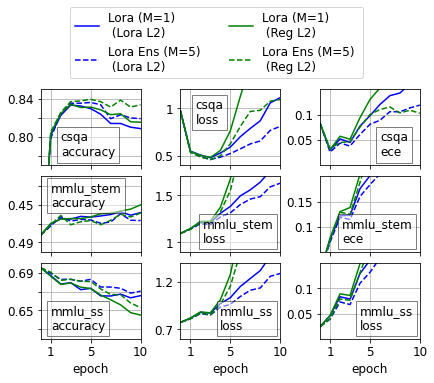

In [9]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 3, figsize=(6, 4))

# Plot accuracies, losses, and ces
for i_dataset in range(3):
    for name_0 in names:
        name = name_0 + "_" + str(i_dataset)
        axs[i_dataset][0].plot(epochs_dir[name],accuracies[name], label=name_0, color = color_dic[name_0], linestyle = linestyles_dic[name_0])
        axs[i_dataset][1].plot(epochs_dir[name],losses[name], label=name_0, color = color_dic[name_0], linestyle = linestyles_dic[name_0])
        axs[i_dataset][2].plot(epochs_dir[name],ces[name], label=name_0, color = color_dic[name_0], linestyle = linestyles_dic[name_0])
    
      
    plt.tight_layout()
    axs[i_dataset][0].grid(b=True)
    axs[i_dataset][1].grid(b=True)
    axs[i_dataset][2].grid(b=True)


# Add legends
# Place a legend at the top of the figure
lines, labels = axs[0][0].get_legend_handles_labels()


SMALL_SIZE = 12
FONTSIZE = 12
alpha = 0.5

x0 = 0
y0 = 0.27
width = 1
height = 1
fig.legend(lines, labels, loc='upper center', ncol=2, bbox_to_anchor=(x0, y0, width, height), fontsize=FONTSIZE)



########## commonsense
ax=axs[0][0]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.77, top=0.85)
ax.set_yticks([0.78, 0.8, 0.82, 0.84])
ax.set_yticklabels(['', '0.80', '', '0.84'], fontsize=SMALL_SIZE)
xtext = 0.2
ytext = 0.12
msg = "csqa\naccuracy"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))

ax=axs[0][1]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.4, top=1.2)
ax.set_yticks([0.5, 1])
ax.set_yticklabels(['0.5', '1'], fontsize=SMALL_SIZE)
xtext = 0.15
ytext = 0.55
msg = "csqa\nloss"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))


ax=axs[0][2]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0, top=0.15)
ax.set_yticks([0.05, 0.1])
ax.set_yticklabels(['0.05', '0.1'], fontsize=SMALL_SIZE)
xtext = 0.6
ytext = 0.12
msg = "csqa\nece"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))


########## dataset_mmlu_stem
ax=axs[1][0]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.52, top=0.44)
ax.set_yticks([0.45, 0.47, 0.49, 0.51])
ax.set_yticklabels(['', '0.45', '', '0.49'], fontsize=SMALL_SIZE)
xtext = 0.1
ytext = 0.6
msg = "mmlu_stem\naccuracy"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))



ax=axs[1][1]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''])
ax.set_ylim(bottom=0.9, top=1.7)
ax.set_yticks([1, 1.5])
ax.set_yticklabels(['1', '1.5'], fontsize=SMALL_SIZE)
xtext = 0.22
ytext = 0.12
msg = "mmlu_stem\nloss"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))




ax=axs[1][2]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''])
ax.set_ylim(bottom=0.05, top=0.2)
ax.set_yticks([0.1, 0.15])
ax.set_yticklabels(['0.1', '0.15'], fontsize=SMALL_SIZE)
xtext = 0.22
ytext = 0.12
msg = "mmlu_stem\nece"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))



############## dataset_mmlu_ss

ax=axs[2][0]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['1', '5', '10'], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.62, top=0.70)
ax.set_yticks([0.63, 0.65, 0.67, 0.69])
ax.set_yticklabels(['', '0.65', '', '0.69'], fontsize=SMALL_SIZE)
ax.set_xlabel('epoch', fontsize=SMALL_SIZE)
xtext = 0.1
ytext = 0.12
msg = "mmlu_ss\naccuracy"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))


ax=axs[2][1]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['1', '5', '10'], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.6, top=1.4)
ax.set_yticks([0.7, 1.2])
ax.set_yticklabels(['0.7', '1.2'], fontsize=SMALL_SIZE)
ax.set_xlabel('epoch', fontsize=SMALL_SIZE)
xtext = 0.4
ytext = 0.12
msg = "mmlu_ss\nloss"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))


ax=axs[2][2]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['1', '5', '10'], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0, top=0.15)
ax.set_yticks([0.05, 0.1])
ax.set_yticklabels(['0.05', '0.1'], fontsize=SMALL_SIZE)
ax.set_xlabel('epoch', fontsize=SMALL_SIZE)
xtext = 0.4
ytext = 0.12
msg = "mmlu_ss\nloss"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))


# Show or save the plot
plt.subplots_adjust(wspace=0.4, hspace=0.15)

#plt.savefig('metrics.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('plot.png')  # Uncomment to save the plot


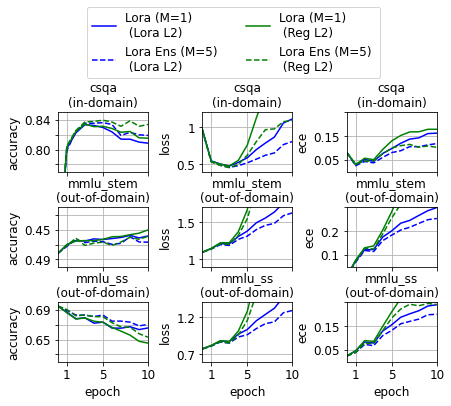

In [11]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 3, figsize=(6, 4))

# Plot accuracies, losses, and ces
for i_dataset in range(3):
    for name_0 in names:
        name = name_0 + "_" + str(i_dataset)
        axs[i_dataset][0].plot(epochs_dir[name],accuracies[name], label=name_0, color = color_dic[name_0], linestyle = linestyles_dic[name_0])
        axs[i_dataset][1].plot(epochs_dir[name],losses[name], label=name_0, color = color_dic[name_0], linestyle = linestyles_dic[name_0])
        axs[i_dataset][2].plot(epochs_dir[name],ces[name], label=name_0, color = color_dic[name_0], linestyle = linestyles_dic[name_0])
    
      
    plt.tight_layout()
    axs[i_dataset][0].grid(b=True)
    axs[i_dataset][1].grid(b=True)
    axs[i_dataset][2].grid(b=True)


# Add legends
# Place a legend at the top of the figure
lines, labels = axs[0][0].get_legend_handles_labels()


SMALL_SIZE = 12
FONTSIZE = 12
alpha = 0.5

x0 = 0
y0 = 0.35
width = 1
height = 1
fig.legend(lines, labels, loc='upper center', ncol=2, bbox_to_anchor=(x0, y0, width, height), fontsize=FONTSIZE)



########## commonsense
ax=axs[0][0]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.77, top=0.85)
ax.set_yticks([0.78, 0.8, 0.82, 0.84])
ax.set_yticklabels(['', '0.80', '', '0.84'], fontsize=SMALL_SIZE)
 ecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('csqa\n(in-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('accuracy', fontsize=SMALL_SIZE)

ax=axs[0][1]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.4, top=1.2)
ax.set_yticks([0.5, 1])
ax.set_yticklabels(['0.5', '1'], fontsize=SMALL_SIZE)
xtext = 0.15
ytext = 0.55
#msg = "csqa\nloss"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('csqa\n(in-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('loss', fontsize=SMALL_SIZE)

ax=axs[0][2]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0, top=0.25)
ax.set_yticks([0.05, 0.15, 0.25])
ax.set_yticklabels(['0.05', '0.15', ''], fontsize=SMALL_SIZE)
xtext = 0.6
ytext = 0.12
#msg = "csqa\nece"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('csqa\n(in-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('ece', fontsize=SMALL_SIZE)


########## dataset_mmlu_stem
ax=axs[1][0]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.52, top=0.44)
ax.set_yticks([0.45, 0.47, 0.49, 0.51])
ax.set_yticklabels(['', '0.45', '', '0.49'], fontsize=SMALL_SIZE)
xtext = 0.1
ytext = 0.6
#msg = "mmlu_stem\naccuracy"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('mmlu_stem\n(out-of-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('accuracy', fontsize=SMALL_SIZE)


ax=axs[1][1]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''])
ax.set_ylim(bottom=0.9, top=1.7)
ax.set_yticks([1, 1.5])
ax.set_yticklabels(['1', '1.5'], fontsize=SMALL_SIZE)
xtext = 0.22
ytext = 0.12
#msg = "mmlu_stem\nloss"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('mmlu_stem\n(out-of-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('loss', fontsize=SMALL_SIZE)



ax=axs[1][2]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''])
ax.set_ylim(bottom=0.05, top=0.3)
ax.set_yticks([0.1, 0.2, 0.3])
ax.set_yticklabels(['0.1', '0.2', ''], fontsize=SMALL_SIZE)
xtext = 0.22
ytext = 0.12
#msg = "mmlu_stem\nece"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('mmlu_stem\n(out-of-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('ece', fontsize=SMALL_SIZE)


############## dataset_mmlu_ss

ax=axs[2][0]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['1', '5', '10'], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.62, top=0.70)
ax.set_yticks([0.63, 0.65, 0.67, 0.69])
ax.set_yticklabels(['', '0.65', '', '0.69'], fontsize=SMALL_SIZE)
ax.set_xlabel('epoch', fontsize=SMALL_SIZE)
xtext = 0.1
ytext = 0.12
#msg = "mmlu_ss\naccuracy"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('mmlu_ss\n(out-of-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('accuracy', fontsize=SMALL_SIZE)

ax=axs[2][1]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['1', '5', '10'], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.6, top=1.4)
ax.set_yticks([0.7, 1.2])
ax.set_yticklabels(['0.7', '1.2'], fontsize=SMALL_SIZE)
ax.set_xlabel('epoch', fontsize=SMALL_SIZE)
xtext = 0.4
ytext = 0.12
#msg = "mmlu_ss\nloss"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('mmlu_ss\n(out-of-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('loss', fontsize=SMALL_SIZE)

ax=axs[2][2]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['1', '5', '10'], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0, top=0.25)
ax.set_yticks([0.05, 0.15, 0.25])
ax.set_yticklabels(['0.05', '0.15', ""], fontsize=SMALL_SIZE)
ax.set_xlabel('epoch', fontsize=SMALL_SIZE)
xtext = 0.4
ytext = 0.12
#msg = "mmlu_ss\nloss"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('mmlu_ss\n(out-of-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('ece', fontsize=SMALL_SIZE)



# Show or save the plot
plt.subplots_adjust(wspace=0.6, hspace=0.6)

plt.savefig('metrics.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('plot.png')  # Uncomment to save the plot


In [385]:
def calculate_agreement(ens_probs_1, ens_probs_2):
    # Move tensors to the same device
    ens_probs_1 = ens_probs_1.to('cpu')
    ens_probs_2 = ens_probs_2.to('cpu')

    p1 = torch.mean(ens_probs_1, dim=0)
    p2 = torch.mean(ens_probs_2, dim=0)
    return torch.sum(torch.ones((p1.shape[0]))[torch.argmax(p1, dim=1)==torch.argmax(p2, dim=1)])/p1.shape[0]

def calculate_variance(ens_probs_1, ens_probs_2):
    # Move tensors to the same device
    ens_probs_1 = ens_probs_1.to('cpu')
    ens_probs_2 = ens_probs_2.to('cpu')

    p1 = torch.mean(ens_probs_1, dim=0)
    p2 = torch.mean(ens_probs_2, dim=0)
    return torch.sum(torch.abs(p1-p2))/(2*p1.shape[0])

In [418]:
import os

epoch  = [str(i) for i in range(11)] 
print(epoch)

path_dir_template = "/mimer/NOBACKUP/groups/snic2022-22-448/lora_ensembles/ens_llm_lora_eval_2/TRAIN_DS/ens/EPOCH/EVAL_DS/member_MEMBER_ID/"
path_files = []
names = []
members = []
epochs = []
modes = []


path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append("Lora (M=1) \n (rank 8)")
color_dic[names[-1]] = "blue"
linestyles_dic[names[-1]] = "-"
members.append(["0","1","2","3","4"])
modes.append("single")
epochs.append(epoch)


path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append("Lora Ens (M=5) \n (rank 8)")
color_dic[names[-1]] = "blue"
linestyles_dic[names[-1]] = "--"
members.append(["0","1","2","3","4"])
modes.append("multiple")
epochs.append(epoch)



path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_32_dr_0_rl2_0_rl2_1.dill")
names.append("Lora (M=1) \n (rank 32)")
color_dic[names[-1]] = '#800080'
linestyles_dic[names[-1]] = "-"
members.append(["0","1","2","3","4"])
modes.append("single")
epochs.append(epoch)


path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_32_dr_0_rl2_0_rl2_1.dill")
names.append("Lora Ens (M=5) \n (rank 32)")
color_dic[names[-1]] = '#800080'
linestyles_dic[names[-1]] = "--"
members.append(["0","1","2","3","4"])
modes.append("multiple")
epochs.append(epoch)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


In [419]:
full_res_dic = {}
epochs_dir = {}

train_dataset = "train_commonsense_qa"
eval_datasets = ["dataset_commonsense_qa", "dataset_mmlu_stem", "dataset_mmlu_ss"]

for i_dataset, eval_dataset in enumerate(eval_datasets):
    for index, path_file in enumerate(path_files):
        name = names[index]+"_"+str(i_dataset)
        for epoch in epochs[index]:
            accumulated_ens_probs = []
            for member_id in members[index]:
                path_dir =  create_full_path(path_file, path_dir_template, 
                                                     epoch = epoch, member_id = member_id, 
                                                     train_dataset = train_dataset, 
                                                     eval_dataset = eval_dataset
                                                    )
                full_path_file = os.path.join(path_dir, path_file)
                res = read_res_from_dill(full_path_file)
                accumulated_ens_probs.append(res['softmax_probs'].unsqueeze(0))
            targets = res['targets']
            accumulated_ens_probs = torch.cat(accumulated_ens_probs)
            add_to_dic(accumulated_ens_probs, name, full_res_dic)
        

In [420]:
agreement = {}
variance = {}
epochs_dir = {}

eval_datasets = ["dataset_commonsense_qa", "dataset_mmlu_stem", "dataset_mmlu_ss"]

for i_dataset, eval_dataset in enumerate(eval_datasets):
    for index, path_file in enumerate(path_files):
        name = names[index]+"_"+str(i_dataset)
        base_model_name = names[-1]+"_"+str(i_dataset)
        for epoch in epochs[index]:
            ens_probs_1 = full_res_dic[base_model_name][int(epoch)]
            ens_probs_2 = full_res_dic[name][int(epoch)]

            if modes[index]=="multiple":

                add_to_dic(calculate_agreement(ens_probs_1, ens_probs_2), name, agreement)
                add_to_dic(calculate_variance(ens_probs_1, ens_probs_2), name, variance)

            else:
                mean_agreement = 0
                mean_variance=0
                for i in range(len(members[index])):
                    mean_agreement+=calculate_agreement(ens_probs_1, ens_probs_2[i:i+1, :, :])/len(members[index])
                    mean_variance+=calculate_variance(ens_probs_1, ens_probs_2[i:i+1, :, :])/len(members[index])

                add_to_dic(mean_agreement, name, agreement)
                add_to_dic(mean_variance, name, variance)


            add_to_dic(epoch, name, epochs_dir)
        

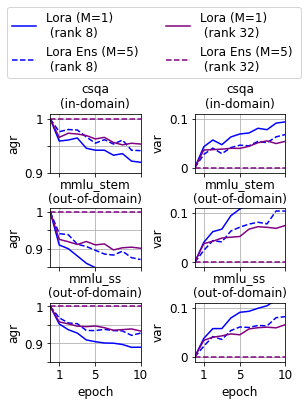

In [423]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2, figsize=(4, 4))

# Plot accuracies, losses, and ces
for i_dataset in range(3):
    for name_0 in names:
        name = name_0 + "_" + str(i_dataset)
        axs[i_dataset][0].plot(epochs_dir[name],agreement[name], label=name_0, color = color_dic[name_0], linestyle = linestyles_dic[name_0])
        axs[i_dataset][1].plot(epochs_dir[name],variance[name], label=name_0, color = color_dic[name_0], linestyle = linestyles_dic[name_0])

      
    plt.tight_layout()
    axs[i_dataset][0].grid(b=True)
    axs[i_dataset][1].grid(b=True)



# Add legends
# Place a legend at the top of the figure
lines, labels = axs[0][0].get_legend_handles_labels()


SMALL_SIZE = 12
FONTSIZE = 12
alpha = 0.5

x0 = 0
y0 = 0.35
width = 1
height = 1
fig.legend(lines, labels, loc='upper center', ncol=2, bbox_to_anchor=(x0, y0, width, height), fontsize=FONTSIZE)



########## commonsense
ax=axs[0][0]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.9, top=1.01)
ax.set_yticks([0.9, 0.95, 1])
ax.set_yticklabels(['0.9', '', '1'], fontsize=SMALL_SIZE)
xtext = 0.2
ytext = 0.12
#msg = "csqa\naccuracy"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('csqa\n(in-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('agr', fontsize=SMALL_SIZE)

ax=axs[0][1]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=-0.01, top=0.11)
ax.set_yticks([0, 0.1])
ax.set_yticklabels(['0', '0.1'], fontsize=SMALL_SIZE)
xtext = 0.15
ytext = 0.55
#msg = "csqa\nloss"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('csqa\n(in-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('var', fontsize=SMALL_SIZE)


########## dataset_mmlu_stem
ax=axs[1][0]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.85, top=1.01)
ax.set_yticks([0.85, 0.9, 0.95, 1])
ax.set_yticklabels(['','0.9', '', '1'], fontsize=SMALL_SIZE)
xtext = 0.1
ytext = 0.6
#msg = "mmlu_stem\naccuracy"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('mmlu_stem\n(out-of-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('agr', fontsize=SMALL_SIZE)


ax=axs[1][1]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['', '', ''])
ax.set_ylim(bottom=-0.01, top=0.11)
ax.set_yticks([0, 0.1])
ax.set_yticklabels(['0', '0.1'], fontsize=SMALL_SIZE)
xtext = 0.22
ytext = 0.12
#msg = "mmlu_stem\nloss"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('mmlu_stem\n(out-of-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('var', fontsize=SMALL_SIZE)



############## dataset_mmlu_ss

ax=axs[2][0]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['1', '5', '10'], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=0.85, top=1.01)
ax.set_yticks([0.85, 0.9, 0.95, 1])
ax.set_yticklabels(['','0.9', '', '1'], fontsize=SMALL_SIZE)
ax.set_xlabel('epoch', fontsize=SMALL_SIZE)
xtext = 0.1
ytext = 0.12
#msg = "mmlu_ss\naccuracy"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('mmlu_ss\n(out-of-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('agr', fontsize=SMALL_SIZE)

ax=axs[2][1]
ax.set_xlim([0, 10])
ax.set_xticks([1, 5, 10])
ax.set_xticklabels(['1', '5', '10'], fontsize=SMALL_SIZE)
ax.set_ylim(bottom=-0.01, top=0.11)
ax.set_yticks([0, 0.1])
ax.set_yticklabels(['0', '0.1'], fontsize=SMALL_SIZE)
ax.set_xlabel('epoch', fontsize=SMALL_SIZE)
xtext = 0.4
ytext = 0.12
#msg = "mmlu_ss\nloss"
#ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=FONTSIZE,
#       bbox=dict(facecolor='white', edgecolor='black', alpha=alpha, boxstyle='square'))
ax.set_title('mmlu_ss\n(out-of-domain)', fontsize=SMALL_SIZE)
ax.set_ylabel('var', fontsize=SMALL_SIZE)



# Show or save the plot
plt.subplots_adjust(wspace=0.6, hspace=0.6)

plt.savefig('agr_var.pdf', format='pdf', bbox_inches='tight')